# Animal Images Classification

Multi-class animal image classification using Tensorflow and transfer learning with ResNet50 imagenet base model weights.

### Data Source

Source Name: Animal Image Classification Dataset

URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset/data

## Imports

In [5]:
import kagglehub
import os, warnings, logging, tensorflow as tf, numpy as np, matplotlib.pyplot as plt, pandas as pd, cv2, keras
import pickle, json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix as cfs_mtx,classification_report, ConfusionMatrixDisplay

%matplotlib inline

# disable GPU detection (comment out to enable GPU)
tf.config.set_visible_devices([], 'GPU')

print("GPU devices:", tf.config.list_physical_devices("GPU"))

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'      # 3 = ERROR only (hides everything)
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

## Data Loading and Processing

### Download dataset

In [7]:
dataset_path = kagglehub.dataset_download("borhanitrash/animal-image-classification-dataset", force_download=False)
dataset_path = dataset_path + "/Animals"

print("dataset_path = ", dataset_path)

dataset_path =  /home/degide/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1/Animals


### Initial Hyperparameter Tuning

In [8]:
random_state = 42
image_size = 224
learning_rate = 0.001
batch_size = 30
max_images_per_class = 1000 # set to None to use all images

### Load and prepare dataset

In [9]:
# List all folders in the dataset directory
folders = sorted(os.listdir(dataset_path))

print(f"Detected classes: {folders}")
print(f"Number of classes: {len(folders)}\n")

# Count images in each category
for category in folders:
    path=os.path.join(dataset_path, category)
    print(f'Total {category} images: {len(os.listdir(path))}')

images = []
labels = []

# Load and preprocess images and use only up to max_images_per_class if specified
for category in folders:
    folder_path = os.path.join(dataset_path, category)
    image_count = 0
    for image_name in os.listdir(folder_path):
        if max_images_per_class is not None and image_count >= max_images_per_class:
            break
        img_path = os.path.join(folder_path, image_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image '{img_path}'. Skipping this file.")
            continue
        img = cv2.resize(img, (image_size, image_size))
        images.append(img)
        labels.append(folders.index(category))
        image_count += 1

print('\nUsed images:',len(images))
print('Used labels:',len(labels))

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
num_classes = len(folders)

# One-hot encode labels
classes = tf.keras.utils.to_categorical(labels, num_classes)

print("One-hot shape:", classes.shape)

Detected classes: ['cats', 'dogs', 'snakes']
Number of classes: 3

Total cats images: 1000
Total dogs images: 1000
Total snakes images: 1000

Used images: 3000
Used labels: 3000
One-hot shape: (3000, 3)


### Preview images

Previewing the first 5 images of each class (category).

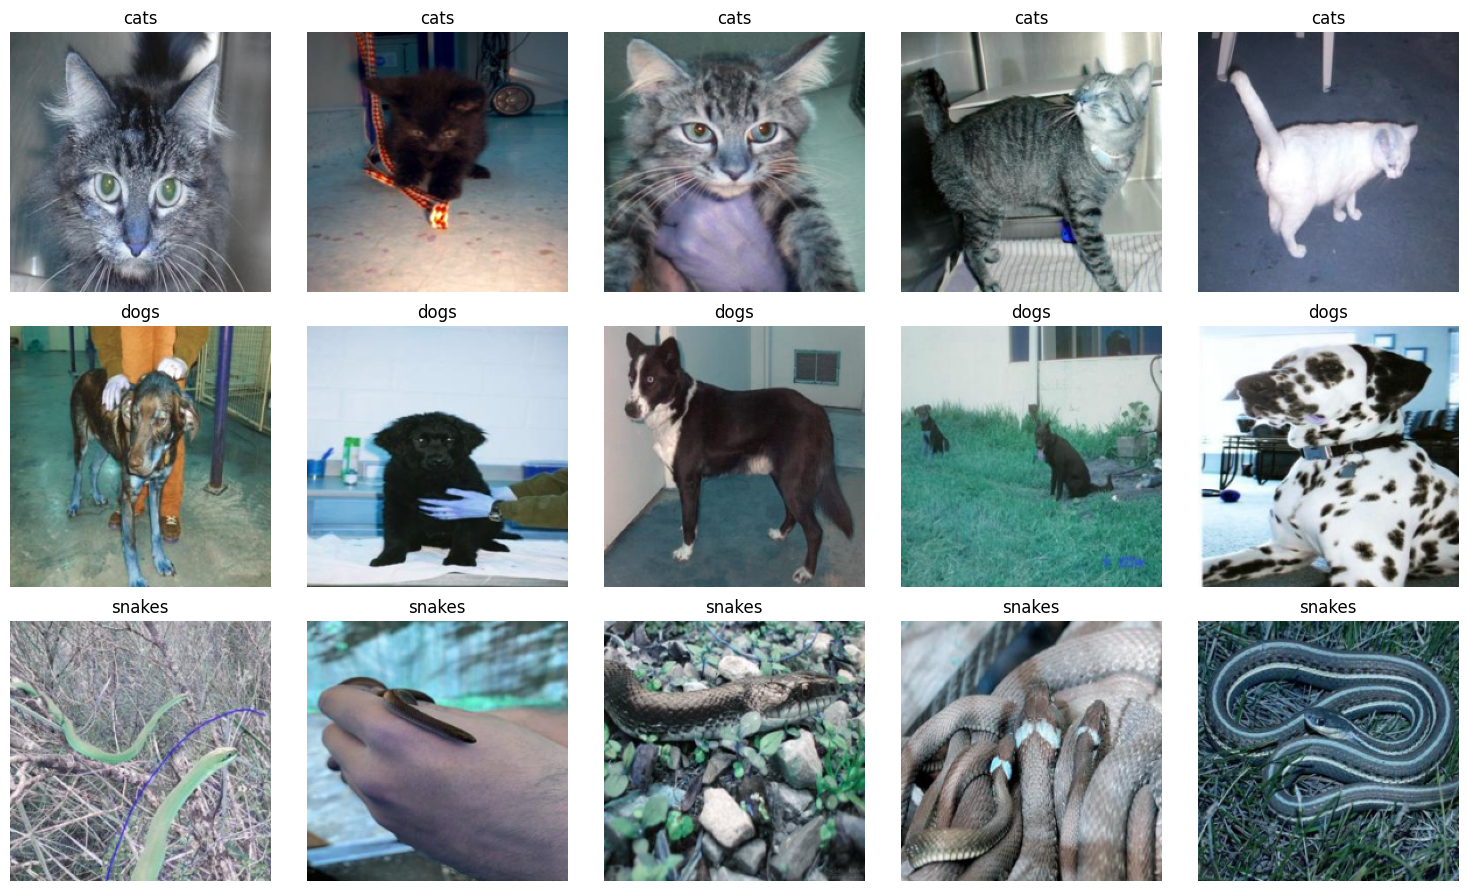

In [10]:
# Preview first 5 images of each category
num_categories = len(folders)
plt.figure(figsize=(15, num_categories * 3))
for i, category in enumerate(folders):
    category_indices = np.where(labels == i)[0]
    for j in range(5):
        if j < len(category_indices):
            plt.subplot(num_categories, 5, i * 5 + j + 1)
            plt.imshow(images[category_indices[j]])
            plt.title(category)
            plt.axis('off')
plt.tight_layout()
plt.show()

### Splitting Dataset

Split the dataset into 85% training, 10% validation, and 5% testing data.

In [11]:
# Splitting Dataset
# Split the dataset into 85% training, 10% validation, and 5% testing data.
x_train, x_test, y_train, y_test = train_test_split(images, classes, test_size = 0.15, random_state = random_state)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = random_state)

print(f"\nTraining Set Size:\nX: {x_train.shape}\nY: {y_train.shape}")
print(f"\nValidation Set Size:\nX: {x_val.shape}\nY: {y_val.shape}")
print(f"\nTest Set Size:\nX: {x_test.shape}\nY: {y_test.shape}")

# Data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size = batch_size)
validation_generator = validation_datagen.flow(x_val, y_val, batch_size = batch_size)


Training Set Size:
X: (2550, 224, 224, 3)
Y: (2550, 3)

Validation Set Size:
X: (225, 224, 224, 3)
Y: (225, 3)

Test Set Size:
X: (225, 224, 224, 3)
Y: (225, 3)


## Model Creation and Training

### Model Creation

Using ResNet50 as the base model, custom layers are added for our use case. In this case, we use transfer learning with the imagenet weights.

In [12]:
# Load pre-trained base model + higher level layers
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))
for lyr in base_model.layers:
  lyr.trainable = False

# Add custom layers on top of base model
model = keras.models.Sequential([
    base_model,
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dense(num_classes, activation = 'softmax')
], name="Animal_Classifier_Model")

# Compile the model
model.compile(
  optimizer=Adam(learning_rate= learning_rate), 
  loss = 'categorical_crossentropy', 
  metrics = ['accuracy', 'precision', 'recall', 'f1_score'],
)

model.summary()

Model: "Animal_Classifier_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,767,875 (94.48 MB)

 Trainable params: 1,180,035 (4.50 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

In [13]:
tf.keras.utils.plot_model(
    model=model,
    to_file='../models/animal_classifier_model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Model Training

In [14]:
# Train the model
history = model.fit(
    train_generator, 
    epochs = 50, 
    validation_data = validation_generator, 
    verbose = 1, 
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, mode='min'), # Reduce learning rate if no improvement for 5 consecutive epochs
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Stop training if no improvement for 10 consecutive epochs
    ]
)

Epoch 1/50


2025-11-27 17:03:34.268885: I external/local_xla/xla/service/service.cc:163] XLA service 0x734cdc067200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-27 17:03:34.268908: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-11-27 17:03:34.650647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764255817.519088   42583 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.6157 - f1_score: 0.6101 - loss: 0.8453 - precision: 0.6643 - recall: 0.4812 - val_accuracy: 0.4711 - val_f1_score: 0.3672 - val_loss: 2.0135 - val_precision: 0.4732 - val_recall: 0.4711 - learning_rate: 0.0010
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6667 - f1_score: 0.6629 - loss: 0.7573 - precision: 0.7177 - recall: 0.5533 - val_accuracy: 0.4311 - val_f1_score: 0.3109 - val_loss: 1.8035 - val_precision: 0.4350 - val_recall: 0.4311 - learning_rate: 0.0010
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6773 - f1_score: 0.6764 - loss: 0.7070 - precision: 0.7330 - recall: 0.5910 - val_accuracy: 0.3600 - val_f1_score: 0.1765 - val_loss: 8.3014 - val_precision: 0.3600 - val_recall: 0.3600 - learning_rate: 0.0010
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7016 - f1_score: 0.7002 - loss: 0.6754 - precision: 0.7436 - recall: 0.6302 - val_accuracy: 0.6000 - val_f1_score: 0.5504

### Evaluation Metrics

Model evaluation using loss, accuracy, precission, f1_score, recall and confusion matrix. Also, classification report is produced for more insights.

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7822 - f1_score: 0.7883 - loss: 0.6028 - precision: 0.7913 - recall: 0.7244

Model Accuracy on Test Set:

|     loss |   accuracy |   precision |   recall |
|---------:|-----------:|------------:|---------:|
| 0.602844 |   0.782222 |    0.791262 | 0.724444 |


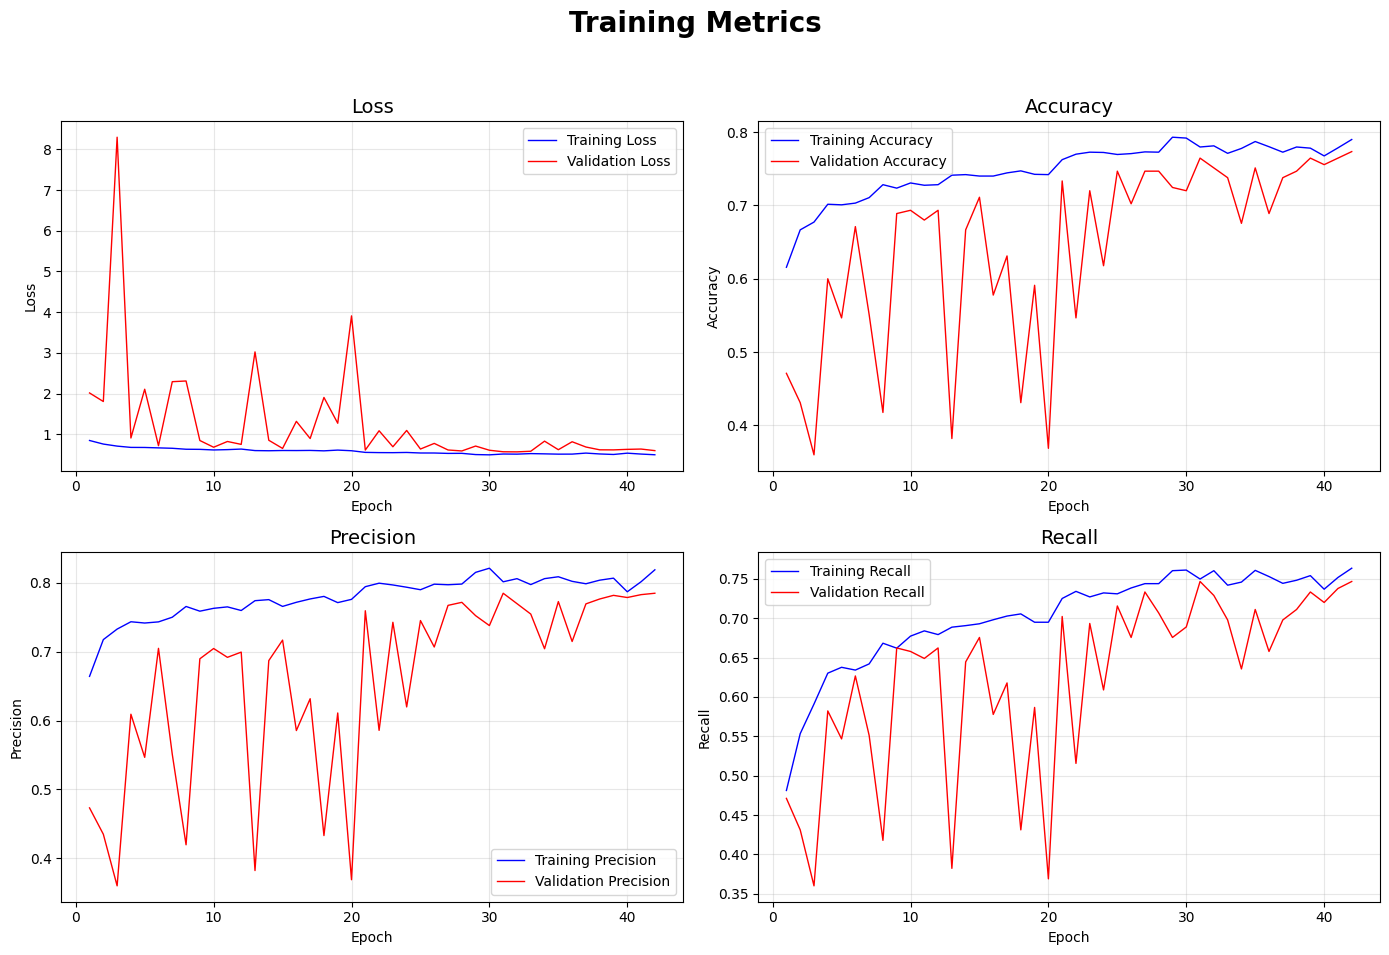

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Classification Report: 
               precision    recall  f1-score   support

        cats       0.79      0.67      0.73        85
        dogs       0.69      0.85      0.76        74
      snakes       0.90      0.85      0.88        66

    accuracy                           0.78       225
   macro avg       0.80      0.79      0.79       225
weighted avg       0.79      0.78      0.78       225



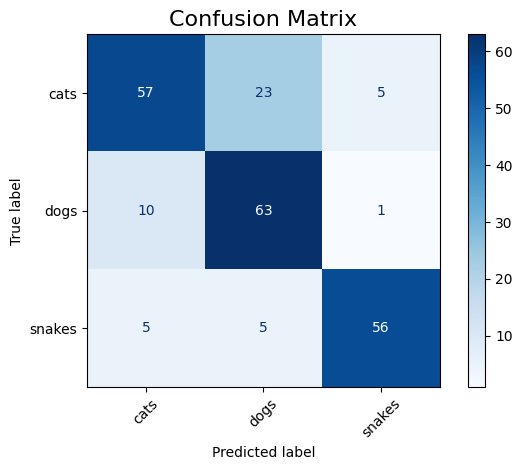

In [15]:
# Showing Model Accuracy on Test Set
loss, accuracy, precision, recall, *rest = model.evaluate(test_generator)
metrics_df = pd.DataFrame([{"loss": loss, "accuracy": accuracy,"precision": precision, "recall": recall}])
print("\nModel Accuracy on Test Set:\n")
print(metrics_df.to_markdown(index=False))

epochs = range(1, len(history.history['loss']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training Metrics', fontsize=20, fontweight='bold')

# 1. Loss
axes[0, 0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=1)
axes[0, 0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=1)
axes[0, 0].set_title('Loss', fontsize=14)
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Accuracy
axes[0, 1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=1)
axes[0, 1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=1)
axes[0, 1].set_title('Accuracy', fontsize=14)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision
axes[1, 0].plot(epochs, history.history['precision'], 'b-', label='Training Precision', linewidth=1)
axes[1, 0].plot(epochs, history.history['val_precision'], 'r-', label='Validation Precision', linewidth=1)
axes[1, 0].set_title('Precision', fontsize=14)
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Recall
axes[1, 1].plot(epochs, history.history['recall'], 'b-', label='Training Recall', linewidth=1)
axes[1, 1].plot(epochs, history.history['val_recall'], 'r-', label='Validation Recall', linewidth=1)
axes[1, 1].set_title('Recall', fontsize=14)
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Classification Report
ts_img = np.concatenate([test_generator[i][0] for i in range(len(test_generator))])
y_pr = model.predict(ts_img)
y_pr = np.argmax(y_pr,axis=1)
lbl = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
lbl = np.argmax(lbl,axis=1)
cls_rpt = classification_report(lbl,y_pr, target_names=folders)
print('Classification Report: \n', cls_rpt)

# Confusion Matrix
cm = cfs_mtx(lbl, y_pr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=folders)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')

plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()


### Save model

Finally, let's save the model and its weights plus the metadata like class names (categories) and evaluation metrics

In [16]:
# Save weights
model.save_weights('../model/animal_classifier_model.weights.h5')

# Save the trained model using pickle 
with open('../model/animal_classifier_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the model info
with open('../model/animal_classifier_model.info.json', 'w', encoding='utf-8') as fp:
    json.dump({
        "classes": sorted(folders), 
        "num_classes": num_classes, 
        "loss": loss, 
        "accuracy": accuracy, 
        "precision": precision, 
        "recall": recall,
        "data_distribution": {
            "cats": len(os.listdir(os.path.join(dataset_path, "cats"))),
            "dogs": len(os.listdir(os.path.join(dataset_path, "dogs"))),
            "snakes": len(os.listdir(os.path.join(dataset_path, "snakes")))
        }
    }, fp, indent=4)

### Test prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted_label= [[2.527085e-38 1.000000e+00 6.612263e-33]]


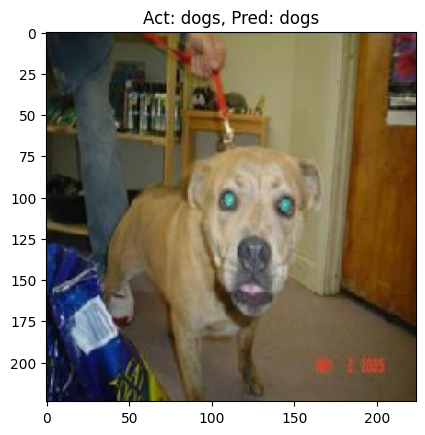

In [17]:
from tensorflow.keras.utils import load_img

# Load saved model
saved_model = pickle.load(open('../model/animal_classifier_model.pkl', 'rb'))

# Load saved model info
saved_info = json.load(open('../model/animal_classifier_model.info.json', 'r', encoding='utf-8'))

actual_label = np.random.choice(saved_info['classes'])

folder_path = os.path.join(dataset_path, actual_label) # Random saved class
random_image_name = np.random.choice(os.listdir(folder_path))
random_image_path = os.path.join(folder_path ,random_image_name)
image = load_img(random_image_path ,target_size=(224, 224))
image = np.array([image])

# predict image
predicted_label = saved_model.predict(image)
print("predicted_label=", predicted_label)
predicted_label = np.argmax(predicted_label)

plt.imshow(image[0])
plt.title(f'Act: {actual_label}, Pred: {sorted(saved_info["classes"])[predicted_label]}')
plt.show()